## Task 0: import data

1. Create folder called data next to main.ipynb
1. Create file called .gitignore next to main.ipynb. In this write: data/
1. Download data between 01-01-2021 and 01-01-2022
    1. Nordpool - hourly prices in DKK
    1. Bornholm network manager - kirkeby Sose Vindpark Active Power
    1. Digital Energy Lab/Weather Observations/DMI - All streams from Bornholm
1. Place data files under /data and rename to production, prices, and weather

## Task 1: Optimization model

In [53]:
import gurobipy as gp
from gurobipy import GRB
import random

# Create optimization model for bidding strategy in DA and balancing market
# Probably good to write it as a class or function for easier repeated use 

#### Set parameters ####
t = 24
C = 500 ### OBS FORKERT!!!!!!!!


# Fixed price and production arrays

lambda_DA = [65.3, 72.1, 80.5, 67.8, 55.9, 64.2, 78.4, 71.3, 85.1, 90.5, 63.4, 70.9, 
             68.1, 75.6, 83.3, 69.4, 61.2, 66.7, 76.5, 82.2, 59.8, 72.4, 88.0, 73.9]  # Day-ahead market prices (EUR/MWh)

lambda_up = [9.4, 11.3, 130.5, 10.9, 90.8, 108.2, 115.9, 103.4, 128.5, 132.2, 104.1, 
             109.6, 120.7, 112.3, 138.4, 121.9, 109.3, 118.7, 126.8, 137.5, 102.5, 
             116.9, 141.6, 115.4]  # Upward regulation prices (EUR/MWh)

lambda_down = [25.4, 32.6, 45.2, 30.1, 23.9, 27.8, 33.7, 31.4, 40.5, 38.1, 27.2, 35.4, 
               29.3, 31.9, 44.1, 36.7, 26.4, 34.7, 41.5, 39.9, 28.5, 37.6, 43.7, 33.1]  # Downward regulation prices (EUR/MWh)

P_proj = [82.3, 77.4, 92.1, 84.6, 65.2, 70.1, 88.3, 79.5, 90.9, 95.4, 69.8, 83.2, 
          76.9, 81.7, 89.2, 85.0, 67.5, 73.8, 91.1, 94.5, 62.3, 78.9, 93.4, 81.5]  # Realized production (MW)

def market_bid(lambda_DA, lambda_up, lambda_down, P_proj,  C = 500):
    
    t = len(P_proj)
    #### Create model ####
    model = gp.Model()

    #### Decision variables ####
    # Production/bid in DA market
    P_bid = model.addVars(t, lb = 0, ub = C, vtype=GRB.CONTINUOUS, name="P_bid")

    # Binary variables for upward and downward regulation
    u = model.addVars(t, vtype=GRB.BINARY, name="upward_regulation")  # Binary for upward regulation
    d = model.addVars(t, vtype=GRB.BINARY, name="downward_regulation")  # Binary for downward regulation

    #### Set Constraints ####
    # Ensure that in each hour, the wind farm cannot be paid for both upward and downward regulation
    model.addConstrs((u[i] + d[i] <= 1 for i in range(t)), "up_or_down")

    # Ensure that the wind farm is either in upward or downward regulation. 
    model.addConstrs((u[i] + d[i] == 1 for i in range(t)), "regulation")

    # Only allow upward or downward regulation to be non-zero when the respective binary is active.  
    model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
    model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")


    #### Set Objective ####
    model.setObjective(
        gp.quicksum(lambda_DA[i] * P_bid[i] for i in range(t)) + 
        gp.quicksum(lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] - lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] for i in range(t)),
        GRB.MAXIMIZE
    )

    #### Optimize ####
    model.setParam('OutputFlag', 0)
    model.optimize()


    #### Print results ####
    """
    print("Optimal production/bid in DA market")
    for i in range(t):
        print(f"t={i}: Bid: {P_bid[i].x}  Projected: {P_proj[i]} Day-ahead price: {lambda_DA[i]} Upward price: {lambda_up[i]} Downward price: {lambda_down[i]}  Binary up: {u[i].x}  Binary down: {d[i].x}")
    
    print("Objective value")
    print(model.objVal)
    """
    bid = model.getAttr("X", P_bid)
    bid = np.array([bid[i] for i in range(t)])
    return bid


P_bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)


## Task 2: Data collection

Want to determine some features that we believe will be useful predictors of future wind power. Could be previous wind power, features of the weather, season or similar. 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import StandardScaler

# Import and format relevant data 
# Import production data
production = pd.read_csv('data/production.csv')
production['ts'] = pd.to_datetime(production['ts']) # Convert to datetime
production = production.set_index('ts') # Set datetime as index
production = production.resample('h').mean() # Resample to hourly data
production = production.rename(columns={"kirkeby Sose Vindpark Active Power | aki_sov_effekt | 804128": "power"}) # Rename column
production = production.fillna(0) # Fill missing values with 0
production = -1 * production # Change sign to positive for production

# Import weather data
weather = pd.read_csv('data/weather.csv')
weather['ts'] = pd.to_datetime(weather['ts'])
weather = weather.set_index('ts')
weather = weather.resample('h').mean()
weather = weather.fillna(0)

# Import electricity prices
prices = pd.read_csv('data/prices.csv')
prices['ts'] = pd.to_datetime(prices['ts'])
prices = prices.set_index('ts')
prices = prices.rename(columns = {
    "Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820": "spotprice"})

# Merge data
data = pd.merge(production, weather, left_index=True, right_index=True)

# Rename columns for easier access
data = data.rename(columns = {
    "Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576": "humidity_Hammer_Odde",
    "Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592" : "temp_max_Hammer_Odde",
    "Observed accumulated precipitation the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/precip_past1h/06197 | 406528": "precipitation_Nex",
    "Observed mean wind speed the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_speed_past1h/06197 | 406512": "windspeed_Nex",
    "Observed maximum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_max_past1h/06197 | 406464": "temp_max_Nex",
    "Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672": "global_radiation_Hammer_Odde",
    "Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608": "temp_min_Hammer_Odde",
    "Observed minimum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_min_past1h/06197 | 406480": "temp_min_Nex",
    "Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560": "temp_mean_Hammer_Odde",
    "Observed mean temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_mean_past1h/06197 | 406432": "temp_mean_Nex",
    "Observed mean humidity past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/humidity_past1h/06197 | 406448": "humidity_Nex",
    "Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640": "windspeed_Hammer_Odde",
    "Observed mean wind direction the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_dir_past1h/06197 | 406496": "winddirection_Nex",
    "Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656": "precipitation_Hammer_Odde",
    "Observed mean intensity of global radiation in the latest hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/radia_glob_past1h/06197 | 406544": "global_radiation_Nex",
    "Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624": "winddirection_Hammer_Odde"
})


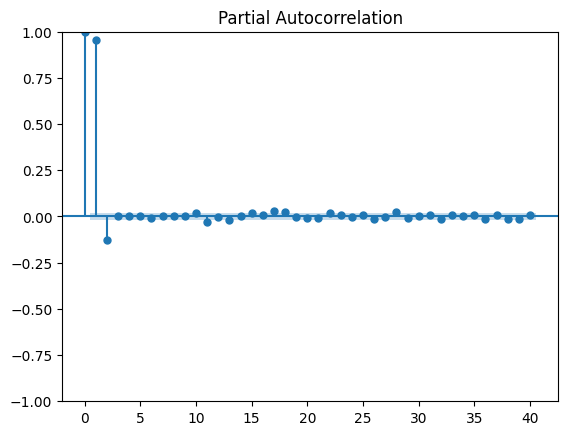

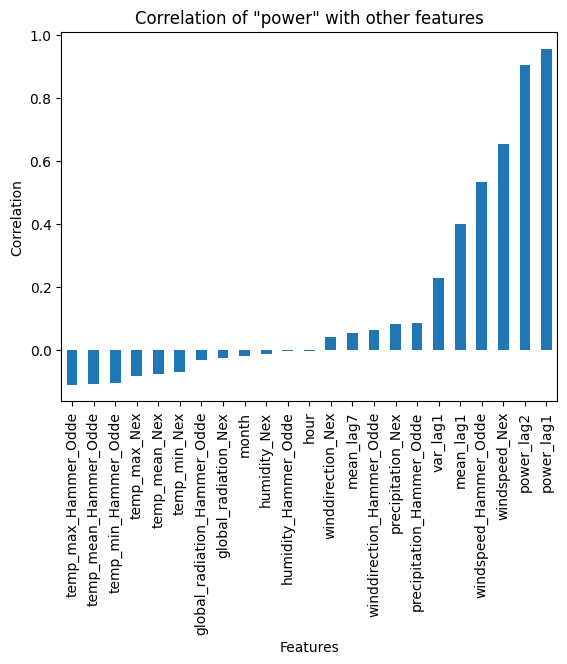

In [31]:
# Check autocorrelation of power production
tsaplots.plot_pacf(production)
plt.show()


### Add more potential features ###
# Add lagged power production as features. Are we allowed to use this?
data['power_lag1'] = data['power'].shift(1)
data['power_lag2'] = data['power'].shift(2)

# Add hour, day and month as features. Might test later with one-hot encoding
data['hour'] = data.index.hour
data['month'] = data.index.month

# Add mean power production the day before as feature
daily_mean_power = data['power'].resample('D').mean()
mean_lag1 = daily_mean_power.shift(1)
data['mean_lag1'] = data.index.normalize().map(mean_lag1)

# Add variance of power production the day before as feature
daily_var_power = data['power'].resample('D').var()
var_lag1 = daily_var_power.shift(1)
data['var_lag1'] = data.index.normalize().map(var_lag1)

# Add mean power production the week before as feature
weekly_mean_power = data['power'].resample('W').mean()
mean_lag7 = weekly_mean_power.shift(1)
data['mean_lag7'] = data.index.normalize().map(mean_lag7)

# Interpolate missing values
data = data.interpolate()

# Check correlation between features
data.corr().iloc[1:, 0].sort_values().plot(kind='bar')
plt.title('Correlation of "power" with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

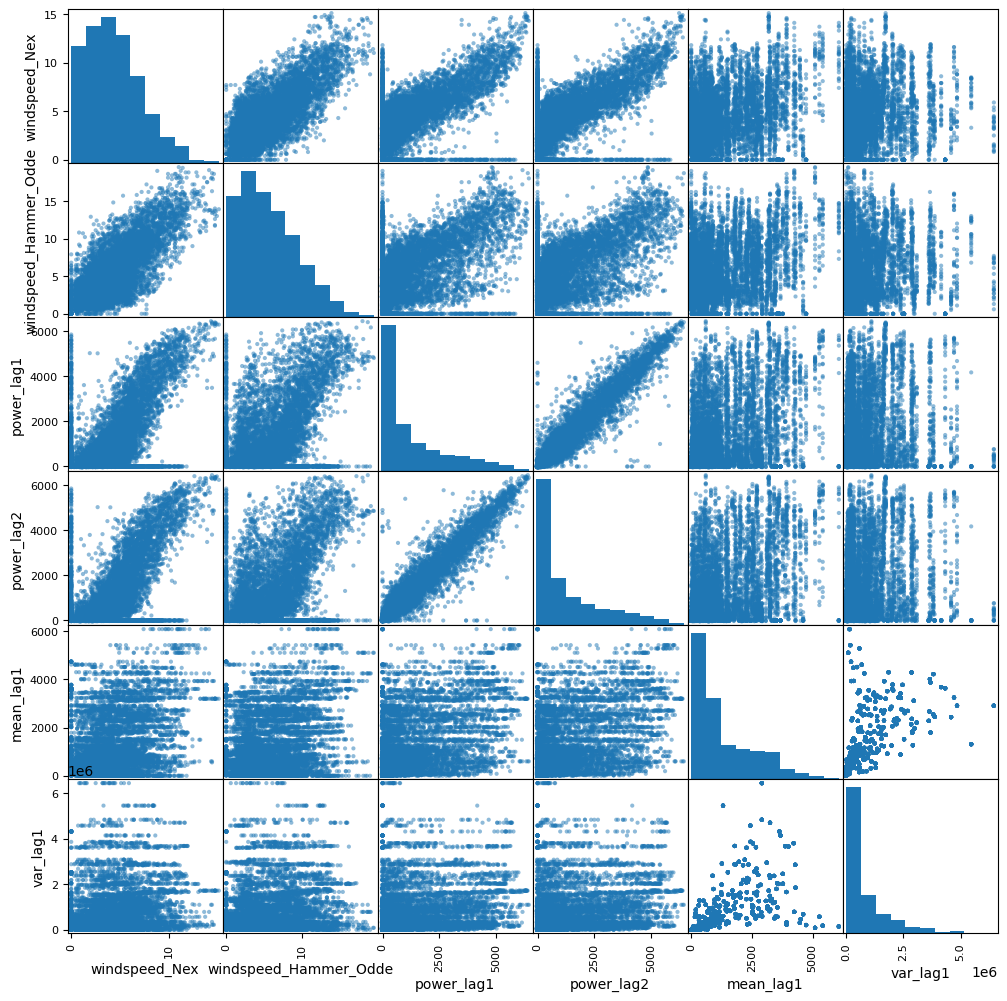

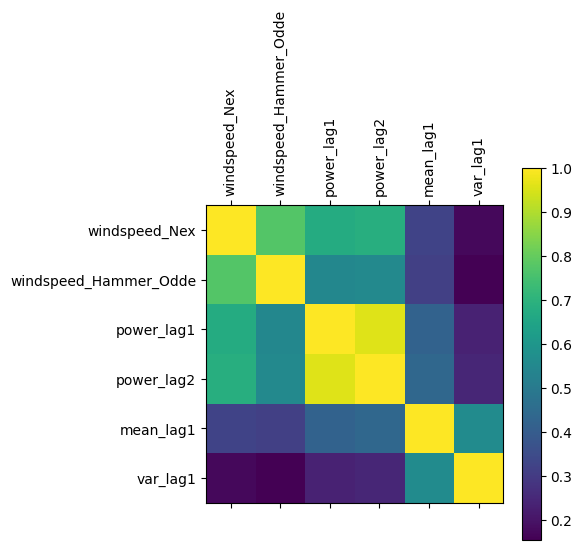

In [32]:
# Look closer at features with high correlation
# Show scatter plots matrix of features with correlation > 0.2
features = data.columns[1:]
corr = data.corr().iloc[1:, 0]
corr = corr[abs(corr) > 0.2]
features = corr.index
pd.plotting.scatter_matrix(data[features], figsize=(12, 12))
plt.show()

plt.matshow(data[features].corr())
plt.xticks(range(len(corr)), corr.index, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.show()


In [33]:

# Select features with correlation > 0.2
x = data[features].dropna()
y = data['power'][x.index]

# Remove first 8 hours to avoid missing values
x = x.iloc[8:]
y = y.iloc[8:]

# Print selected features
print(x.columns)

# Scale data 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Add bias term to input data
X = np.concatenate([np.ones((x.shape[0], 1)), x_scaled], axis=1)

# Split data into training and test set for time series data
split_fraction = 0.8
split_index = int(len(x) * split_fraction)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Index(['windspeed_Nex', 'windspeed_Hammer_Odde', 'power_lag1', 'power_lag2',
       'mean_lag1', 'var_lag1'],
      dtype='object')


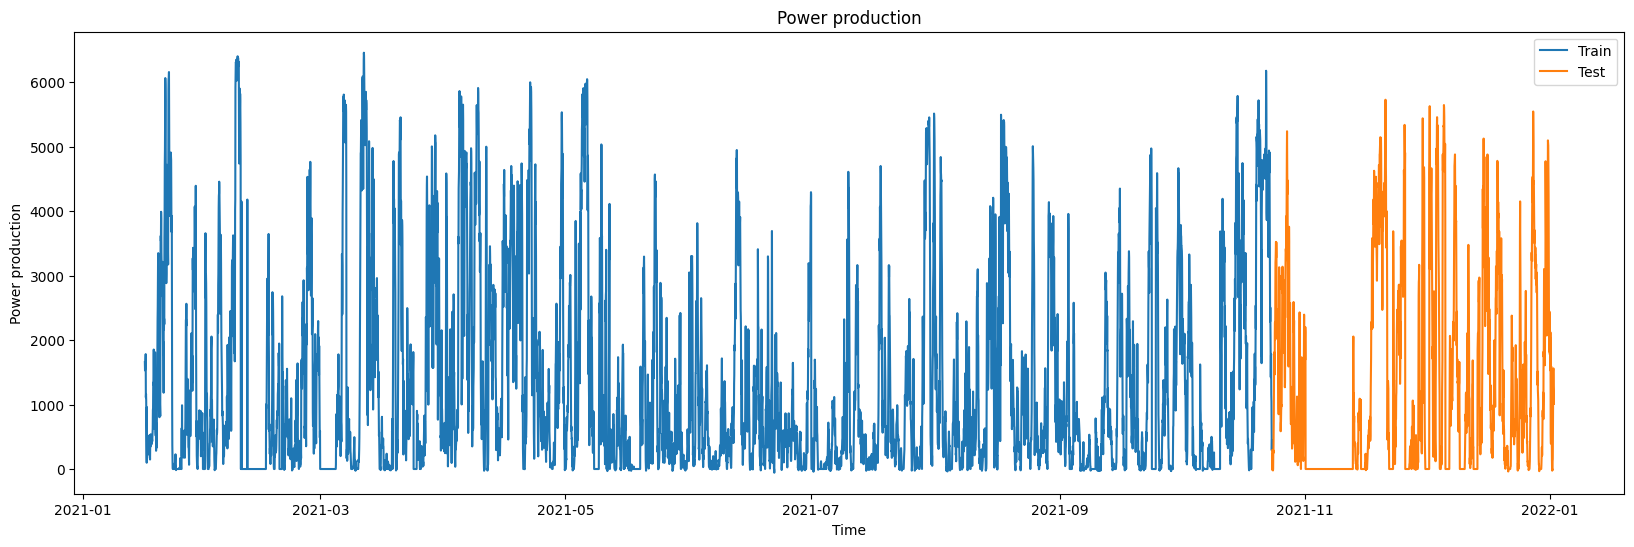

In [34]:
# Plot target variable against time, split into training and test set
plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

## Task 3: Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression


# Implement gradient descent

def gradient_descent(X_train, max_iterations=10000, alpha = 0.01):
    # Initial guess of coefficients
    theta = np.zeros(X_train.shape[1])

    # Number of observations
    m = len(X_train)
    
    for _ in range(max_iterations):

        # Linear regression prediction
        h = theta @ X_train.T

        # The partial derivatives of the cost function
        dt = (1/m) * ((h - y_train.T) @ X_train)

        # Update the coefficients
        theta = theta - alpha * dt

        # Break if the change in coefficients is small
        if np.linalg.norm(alpha * dt) < 1e-6:
            return theta
        
    return theta


# Implement closed form solution
theta_cfs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Compare the two solutions
print(gradient_descent(X_train))
print(theta_cfs)




[1317.62307261   18.80215945   17.54602934 1621.74749595 -183.75530306
    2.09384677    3.75666367]
[1317.63313504   19.18251407   17.42290132 1635.29375721 -197.66537385
    2.47890013    3.68245147]


RMSE: 452.8137090937094
MAE: 269.067645506404
R2: 0.9144488979992383


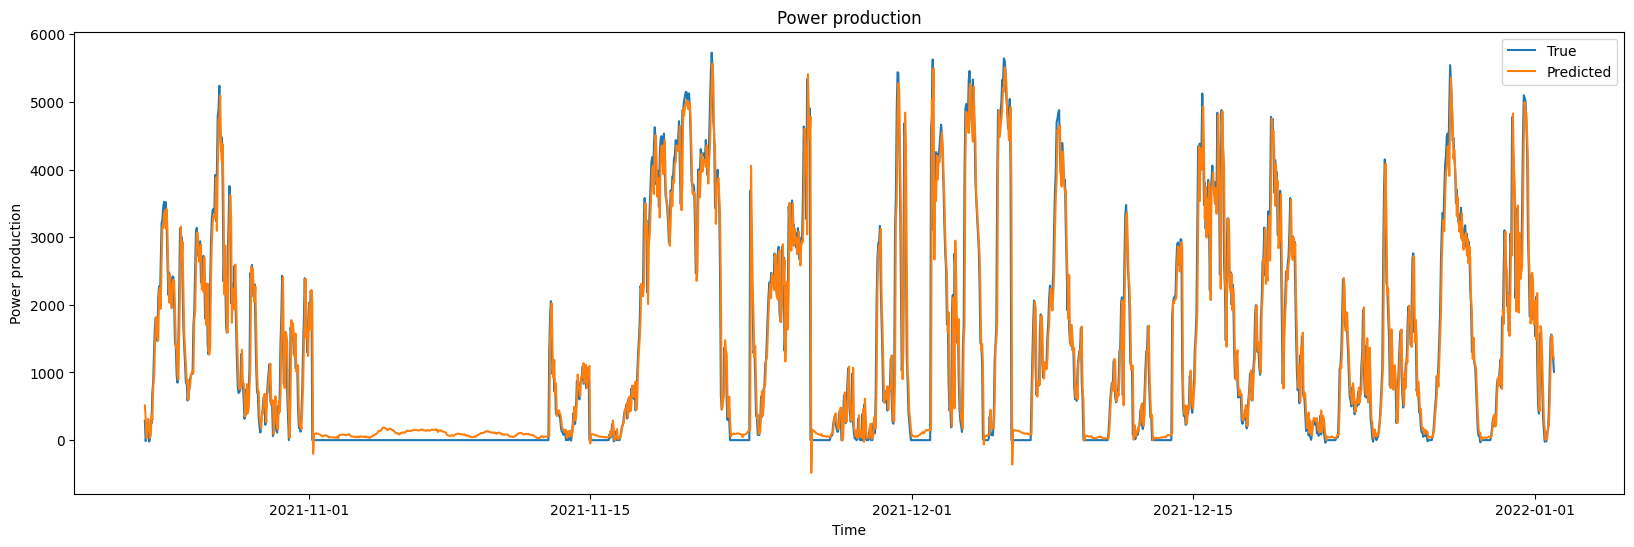

In [36]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions
y_OLS = X_test @ theta_cfs

# Calculate metrics
rmse = np.sqrt(np.mean((y_test - y_OLS)**2))
mae = mean_absolute_error(y_test, y_OLS)
r2 = r2_score(y_test, y_OLS)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_OLS, label='Predicted')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

## Task 4: Non-linear regression

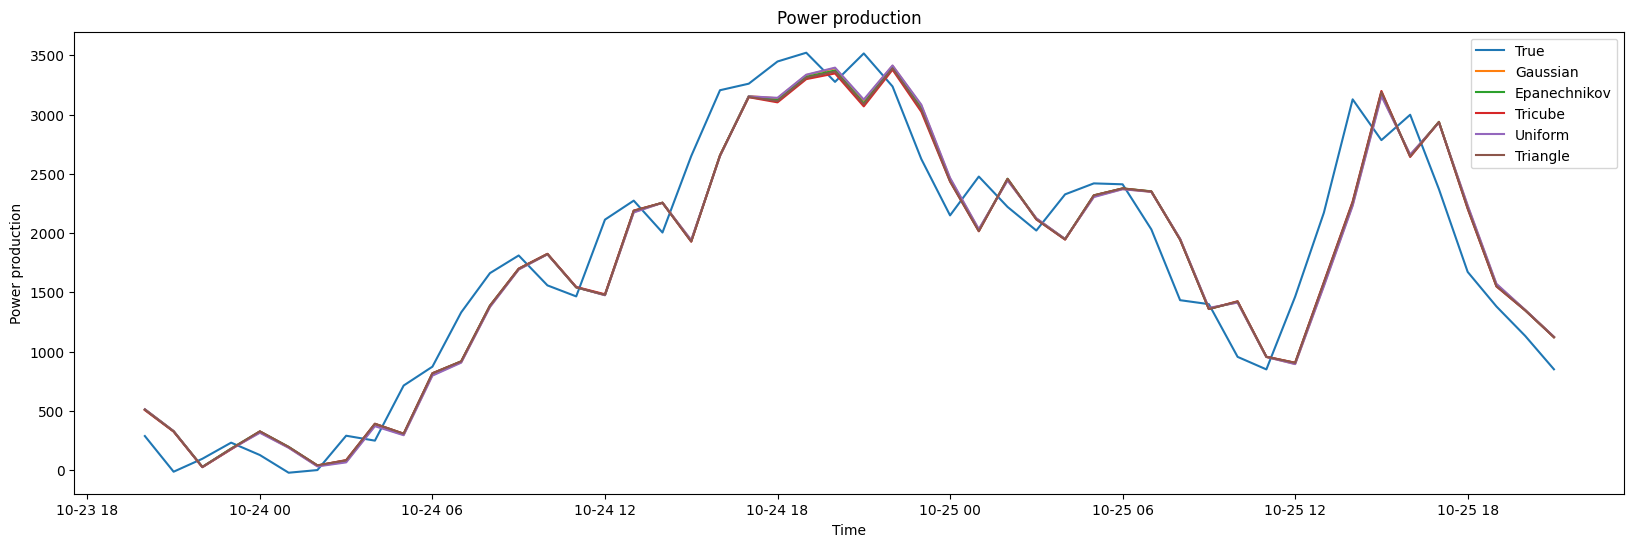

In [11]:
from sklearn.preprocessing import PolynomialFeatures

# 4.1: Implement polynomial regression


y_poly = ... # Implement polynomial regression

# 4.2: Implement weighted least squares
# Possible kernels
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return kern

def tricube(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return kern

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return kern


# Implement locally weighted least squares
def lwls(X_train, y_train, X_test, kernel=gaussian, bandwidth=0.1):
    y_pred = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        # Calculate weights
        weights = kernel(np.linalg.norm(X_train - x, axis=1) / bandwidth)
        W = np.diag(weights)
        
        # Calculate theta
        theta = np.linalg.inv(X_train.T @ W @ X_train) @ X_train.T @ W @ y_train
        
        # Make prediction
        y_pred[i] = x @ theta
        
    return y_pred

# Make predictions
n = 50
band = 5
y_lwls_gauss = lwls(X_train, y_train, X_test[:n], kernel=gaussian, bandwidth=band)
y_lwls_epan = lwls(X_train, y_train, X_test[:n], kernel=epanechnikov, bandwidth=band)
y_lwls_tricube = lwls(X_train, y_train, X_test[:n], kernel=tricube, bandwidth=band)
y_lwls_uniform = lwls(X_train, y_train, X_test[:n], kernel=uniform, bandwidth=band)
y_lwls_triangle = lwls(X_train, y_train, X_test[:n], kernel=triangle, bandwidth=band)

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test.index[:n], y_test[:n], label='True')
plt.plot(y_test.index[:n], y_lwls_gauss, label='Gaussian')
plt.plot(y_test.index[:n], y_lwls_epan, label='Epanechnikov')
plt.plot(y_test.index[:n], y_lwls_tricube, label='Tricube')
plt.plot(y_test.index[:n], y_lwls_uniform, label='Uniform')
plt.plot(y_test.index[:n], y_lwls_triangle, label='Triangle')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()



## Task 5: Regularization

RMSE Lasso: 452.8149085389451
MAE Lasso: 269.0652906019461
RMSE Ridge: 452.81379915821157
MAE Ridge: 269.06819198132587


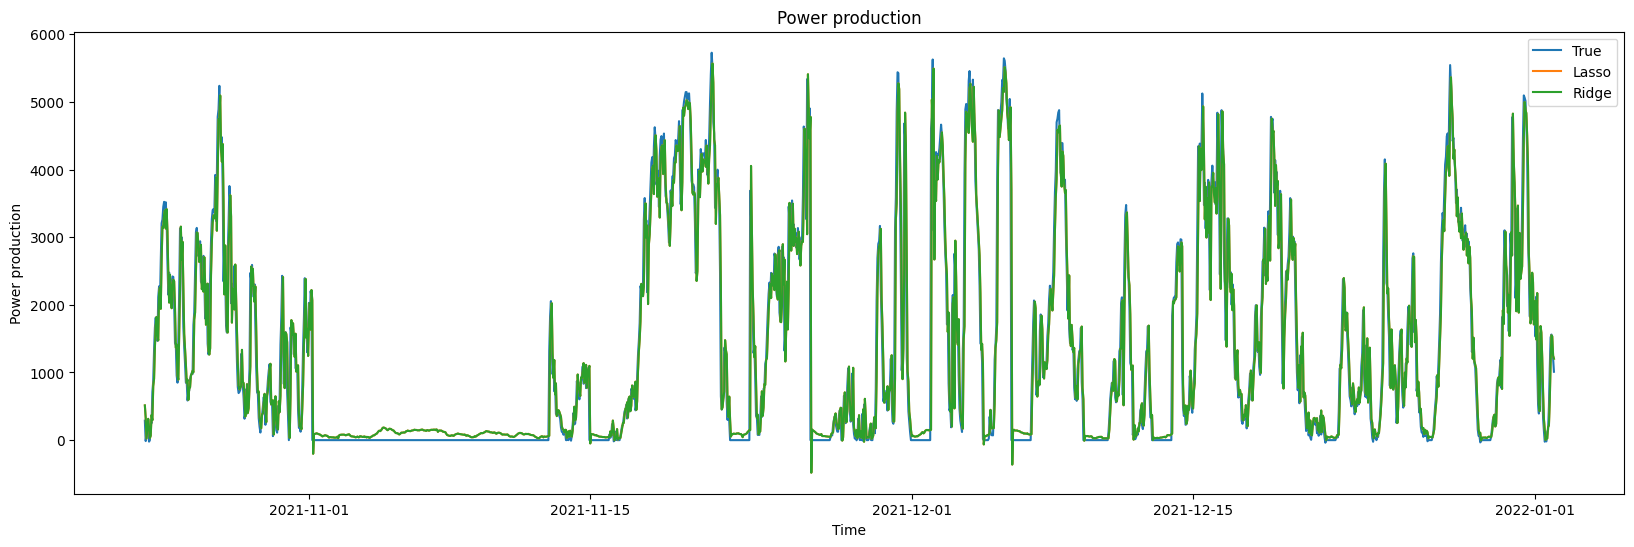

In [37]:
from sklearn.linear_model import Lasso, Ridge

# Implement Lasso regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_lasso = lasso.predict(X_test)

# Implement Ridge regression
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(X_test)

# Evaluate models
rmse_lasso = np.sqrt(np.mean((y_test - y_lasso)**2))
mae_lasso = mean_absolute_error(y_test, y_lasso)

rmse_ridge = np.sqrt(np.mean((y_test - y_ridge)**2))
mae_ridge = mean_absolute_error(y_test, y_ridge)

print(f"RMSE Lasso: {rmse_lasso}")
print(f"MAE Lasso: {mae_lasso}")

print(f"RMSE Ridge: {rmse_ridge}")
print(f"MAE Ridge: {mae_ridge}")

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_lasso, label='Lasso')
plt.plot(y_test.index, y_ridge, label='Ridge')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()


In [51]:
# Temporarily set values for poly and lwls
y_poly = np.ones(len(y_test))
y_lwls_gauss = np.ones(len(y_test))

model_names = ['OLS', 'poly', 'y_lwls_gauss', 'Lasso', 'Ridge']
projections = pd.DataFrame({'OLS': y_OLS, 'poly': y_poly, 'y_lwls_gauss': y_lwls_gauss, 'Lasso': y_lasso, 'Ridge': y_ridge}, index=y_test.index)

test_data = pd.concat([y_test, prices, projections], axis=1, join='inner')

# Add mock data for lambda_up and lambda_down
test_data['lambda_down'] = np.ones(len(test_data))
test_data['lambda_up'] = np.ones(len(test_data))


test_data

,power,spotprice,OLS,poly,y_lwls_gauss,Lasso,Ridge,lambda_down,lambda_up
ts,,,,,,,,,
2021-10-23 20:00:00,287.349983,"1562,44",513.422098,1.0,1.0,513.361223,513.418739,1.0,1.0
2021-10-23 21:00:00,-13.653103,"1284,18",329.285778,1.0,1.0,329.275952,329.288770,1.0,1.0
2021-10-23 22:00:00,95.571832,"1120,87",25.062888,1.0,1.0,25.074298,25.069138,1.0,1.0
2021-10-23 23:00:00,231.600774,"791,63",177.782658,1.0,1.0,177.725820,177.780403,1.0,1.0
2021-10-24 00:00:00,127.073792,"763,88",314.993246,1.0,1.0,314.942532,314.991358,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,1818.334499,"357,01",1725.972299,1.0,1.0,1726.070780,1725.986845,1.0,1.0
2021-12-31 20:00:00,2441.932761,"252,53",1805.010412,1.0,1.0,1804.994309,1805.010544,1.0,1.0
2021-12-31 21:00:00,2379.814753,"245,99",2474.618923,1.0,1.0,2474.505092,2474.605473,1.0,1.0


## Task 6: Revenue calculation for evaluation

In [54]:
def revenue(real, P_proj, lambda_up, lambda_down):
    bid = market_bid(real, lambda_up, lambda_down, P_proj)
    rev = np.sum(bid * real + lambda_down * np.maximum(real - bid, 0) - lambda_up * np.maximum(bid - real, 0))
    return rev


revenues = pd.DataFrame(index=y_test.index, columns=model_names).resample('D').sum()

for model in model_names:
    for date in revenues.index:
        daily_data = test_data.loc[test_data.index == date]
        revenues[date] = revenue(daily_data["spotprice"], daily_data[model], daily_data["lambda_up"], daily_data["lambda_down"])


C:\Users\jacob\AppData\Local\Temp\ipykernel_17728\943710582.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
C:\Users\jacob\AppData\Local\Temp\ipykernel_17728\943710582.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")
C:\Users\jacob\AppData\Local\Temp\ipykernel_17728\943710582.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will 

TypeError: can't multiply sequence by non-int of type 'Var'

## Task 7 (optional): Suggestion for improvement

ValueError: x and y must be the same size

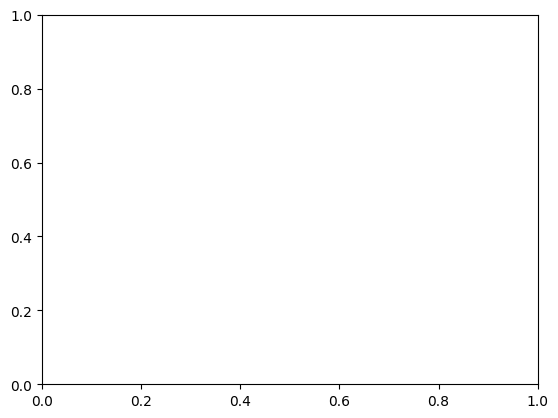

In [55]:
from sklearn.cluster import KMeans


# Implement clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(x).astype('int')

# Plot clusters
plt.scatter(x, y, c=clusters)
plt.show()

# Implement the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

## Task 8: Model 2